---

## **Plotando Imagens GOES-13**

---

**OBJETIVO:** Aprender como plotar imagens do canal **infravermelho**. Para isto usaremos os dados do sensor [GOES Imager](https://space.oscar.wmo.int/instruments/view/imager_goes_12_15) do satélite [Geostationary Operational Environmental Satellite (GOES-13)](https://space.oscar.wmo.int/satellites/view/goes_13).

---


**DADOS DE ENTRADA**: Arquivos de temperatura de brilho do canal **infravermelho**

1. $\underline{Infravermelho}$: CH4 - 10.7 µm
- **Tipo do dado:** matriz de 1714 linhas x 1870 colunas  
- **Formato do dado:** arquivo BINÁRIO
- **Nome do arquivo:** S10236964_201406120000
- **Fonte dos dados:** FTP do [CPTEC/INPE](http://ftp.cptec.inpe.br/goes/goes13/retangular_4km/)

---

**DADOS DE SAÍDA:** Figuras de temperatura de brilho.
- **Tipo do dado:** Figura
- **Formato do dado:** arquivos JPG
- **Imagens geradas:**
    1. goes13_ch4_20200123_1700.jpg


---

**PROCEDIMENTO REALIZADO:** Os seguintes procedimentos são realizados nesse código:
1.   Instalação de bibliotecas
2.   Monta o google drive
3.   Define o caminho do google drive
4.   Importação das bibliotecas
5.   Download shapefiles do IBGE
6.   Baixa os dados de satélite
7.   Plota imagem do infravermelho para América do Sul

---
**OBSERVAÇÕES IMPORTANTES**:
1. Caminho do seu drive

---
- **Realizado por:** Enrique V. Mattos - 23/08/2022
- **Atualizado por:** Enrique V. Mattos - 05/07/2023


---

# **1° Passo:** Instalando as bibliotecas

In [ ]:
# Instalando o proplot (usado para gerar Mapas também)
!pip install -q proplot

# Instalando o cartopy (usado para gerar Mapas)
!pip uninstall shapely --yes
!pip install -q shapely cartopy --no-binary shapely --no-binary cartopy
!wget https://raw.githubusercontent.com/SciTools/cartopy/master/tools/cartopy_feature_download.py
!python cartopy_feature_download.py physical

Chegando aqui, será necessário fazer a tediosa **Reinicialização do Ambiente de Execução** (acessar *Ambiente de execução* que esta na barra de ferramentas e clicar em *Reiniciar Ambiente de Execução* e rodar novamente a célula anterior de instalações) e ter que instalar todos os pacotes de novo. Isso é necessário tanto para poder usar sem problemas o `Proplot` quanto o `CartoPy` na nossa sessão do Colab, então a partir desse ponto não teremos mais que nos preocupar com a preparação do ambiente virtual.

In [ ]:
# Instalando o Salem (usado para mascarar regiões)
!pip install -q rasterio
!pip install -q pyproj
!pip install -q geopandas
!pip install -q salem

# **2° Passo:** Montando drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **3° Passo:** Caminho do diretório
- Insira aqui o caminho da pasta do seu Google Drive onde esta o código dessa aula.

In [ ]:
dir = '/content/drive/MyDrive/PYHTON/00_GITHUB/4_SATELITE/'

# **4° Passo:** Importando as bibliotecas

In [ ]:
import proplot as pplt
import xarray as xr
import numpy as np
from matplotlib.colors import LinearSegmentedColormap # interpolação linear para as cores dos mapas
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import os
import glob
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
from time import process_time
from matplotlib import cm                           # Colormap handling utilities
import shutil
from datetime import datetime
import salem

import sys
sys.path.append(f'{dir}input/')
from cpt_convert import loadCPT

import warnings
warnings.filterwarnings("ignore")

# **5° Passo:** Download shapefiles do IBGE

In [ ]:
# baixando e descomprimindo shapefiles dos estados do Brasil
print('------ BAIXANDO OS SHAPEFILES DE TODOS OS ESTADOS DO BRASIL ------')
!wget -c https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/Brasil/BR/br_unidades_da_federacao.zip
!unzip -o /content/br_unidades_da_federacao.zip

------ BAIXANDO OS SHAPEFILES DE TODOS OS ESTADOS DO BRASIL ------
--2023-07-05 17:42:37--  https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/Brasil/BR/br_unidades_da_federacao.zip
Resolving geoftp.ibge.gov.br (geoftp.ibge.gov.br)... 191.233.136.86
Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|191.233.136.86|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  /content/br_unidades_da_federacao.zip
 extracting: BR_UF_2019.cpg          
  inflating: BR_UF_2019.dbf          
  inflating: BR_UF_2019.prj          
  inflating: BR_UF_2019.shp          
  inflating: BR_UF_2019.shx          


In [ ]:
# lendo shapefile de todos estados brasileiros
estados_ibge = salem.read_shapefile('/content/BR_UF_2019.shp')
estados_ibge

,CD_UF,NM_UF,SIGLA_UF,NM_REGIAO,geometry,min_x,max_x,min_y,max_y
0,11,Rondônia,RO,Norte,"POLYGON ((-65.38150 -10.42907, -65.38013 -10.4...",-66.810253,-59.774357,-13.693700,-7.975868
1,12,Acre,AC,Norte,"POLYGON ((-71.07772 -9.82774, -71.07817 -9.828...",-73.990450,-66.623754,-11.145561,-7.111824
2,13,Amazonas,AM,Norte,"POLYGON ((-69.83766 -3.68659, -69.82555 -3.620...",-73.801558,-56.097558,-9.818046,2.246631
3,14,Roraima,RR,Norte,"POLYGON ((-63.96008 2.47313, -63.96041 2.47416...",-64.825254,-58.886884,-1.580633,5.271841
4,15,Pará,PA,Norte,"MULTIPOLYGON (((-51.43248 -0.47334, -51.42949 ...",-58.898328,-46.061425,-9.841153,2.591027
5,16,Amapá,AP,Norte,"MULTIPOLYGON (((-50.45011 2.10924, -50.44715 2...",-54.876250,-49.875682,-1.236176,4.508817
6,17,Tocantins,TO,Norte,"POLYGON ((-48.23163 -5.94614, -48.23011 -5.938...",-50.742064,-45.699265,-13.467713,-5.168381
7,21,Maranhão,MA,Nordeste,"MULTIPOLYGON (((-44.53830 -2.02124, -44.53742 ...",-48.755151,-41.795884,-10.261765,-1.049328
8,22,Piauí,PI,Nordeste,"POLYGON ((-42.91539 -6.64607, -42.91645 -6.644...",-46.028207,-40.370510,-10.928756,-2.749753
9,23,Ceará,CE,Nordeste,"POLYGON ((-41.18292 -4.01797, -41.18552 -4.017...",-41.423518,-37.252659,-7.858182,-2.784323


#**PARTE 1)**: Define informações do satélite GOES-13

In [40]:
# tamanho da matriz do GOES-13
nx, ny = 1870, 1714

# limites da grade
lonmin, lonmax, latmin, latmax = -100., -25.24, -56.00, 12.52

# vetor de latitude e longitudes
lat = np.linspace(latmin, latmax, ny)
lon = np.linspace(lonmin, lonmax, nx)

# reprojeta as lons e lats do radar para uma matriz bidimensional
lon_sat, lat_sat = np.meshgrid(lon, lat)

# cria matriz de latitudes e longitudes para arquivo netcdf
#lons = np.arange(lonmin, lonmax, dx)
#lats = np.arange(latmax, latmin, -dy)
lats = np.linspace(latmin, latmax, ny)
lons = np.linspace(lonmin, lonmax, nx)

#**PARTE 2)**: Transforma binário para Netcdf

Lista os arquivos binários que estão na pasta input

In [53]:
files = glob.glob(f'{dir}input/S10236964_*')
files

['/content/drive/MyDrive/PYHTON/00_GITHUB/4_SATELITE/input/S10236964_201406120600',
 '/content/drive/MyDrive/PYHTON/00_GITHUB/4_SATELITE/input/S10236964_201406120000']

Define a função que transforma arquivo binário para netcdf e salva

In [54]:
#-----------------------------------------------------------------------------------
#  Função que transforma arquivo binário do GOES-13 para netcdf
#-----------------------------------------------------------------------------------
def bin_to_netcdf_goes13(ny, nx, latmin, latmax, lonmin, lonmax, file):

    """
    Função que transforma arquivo binário do GOES-13 para netcdf

    Parâmetros:
                ny (int): quantidade de pontos em latitudes
                nx (int): quantidade de pontos em longitude
                latmin (float): latitude mínima da grade
                latmax (float): latitude máxima da grade
                lonmin (float): longitude mínima da grade
                lonmax (float): longitude máxima da grade
                file (str): nome do arquivo binário

    Retorna:
                arquivo netcdf

    Exemplo:
                nx, ny, lonmin, lonmax, latmin, latmax = 1870, 1714, -100., -25.24, -56.00, 12.52
                bin_to_netcdf_goes13(ny, nx, latmin, latmax, lonmin, lonmax, f'{dir}input/S10236964_201406140000')
    """

    # cria matriz de latitudes e longitudes para arquivo netcdf
    lats = np.linspace(latmin, latmax, ny)
    lons = np.linspace(lonmin, lonmax, nx)

    # extrai o nome do arquivo
    file_name = os.path.basename(os.path.splitext(file)[0])

    # leitura do arquivo
    tmp = np.fromfile(f'{file}', np.int16)

    # ajusta a dimensão da matriz
    data = tmp.reshape(ny, nx)

    # inverte a matriz
    #data = np.flipud(data)

    # divide por 100 e transforma para Celsius
    data = (data/100.)-273.15

    # transforma para dataSet do Xarray
    data_vars = {'tir':(('lat', 'lon'), data, {'units': 'oC', 'long_name':'Temperatura de Brilho CH4 GOES-13'})}
    coords = {'lat': lats, 'lon': lons}
    attrs = {'creation_data':str(datetime.now()), 'author':'Enrique Mattos', 'email': 'enrique.vmattos@gmail.com'}
    temp_nc = xr.Dataset(data_vars=data_vars, coords=coords, attrs=attrs)

    # salva em netcdf
    temp_nc.to_netcdf(f'{file_name}.nc')

    return

In [55]:
# loop dos arquivos binários
for file in files:
    bin_to_netcdf_goes13(ny, nx, latmin, latmax, lonmin, lonmax, file)

# **PARTE 3)**: Plota imagem do infravermelho - América do Sul

In [56]:
# lista dos arquivos netcdf
files_nc = glob.glob('/content/S10236964_*nc')
files_nc

['/content/S10236964_201406120000.nc', '/content/S10236964_201406120600.nc']

....PROCESSANDO--->>> /content/S10236964_201406120000.nc
....PROCESSANDO--->>> /content/S10236964_201406120600.nc


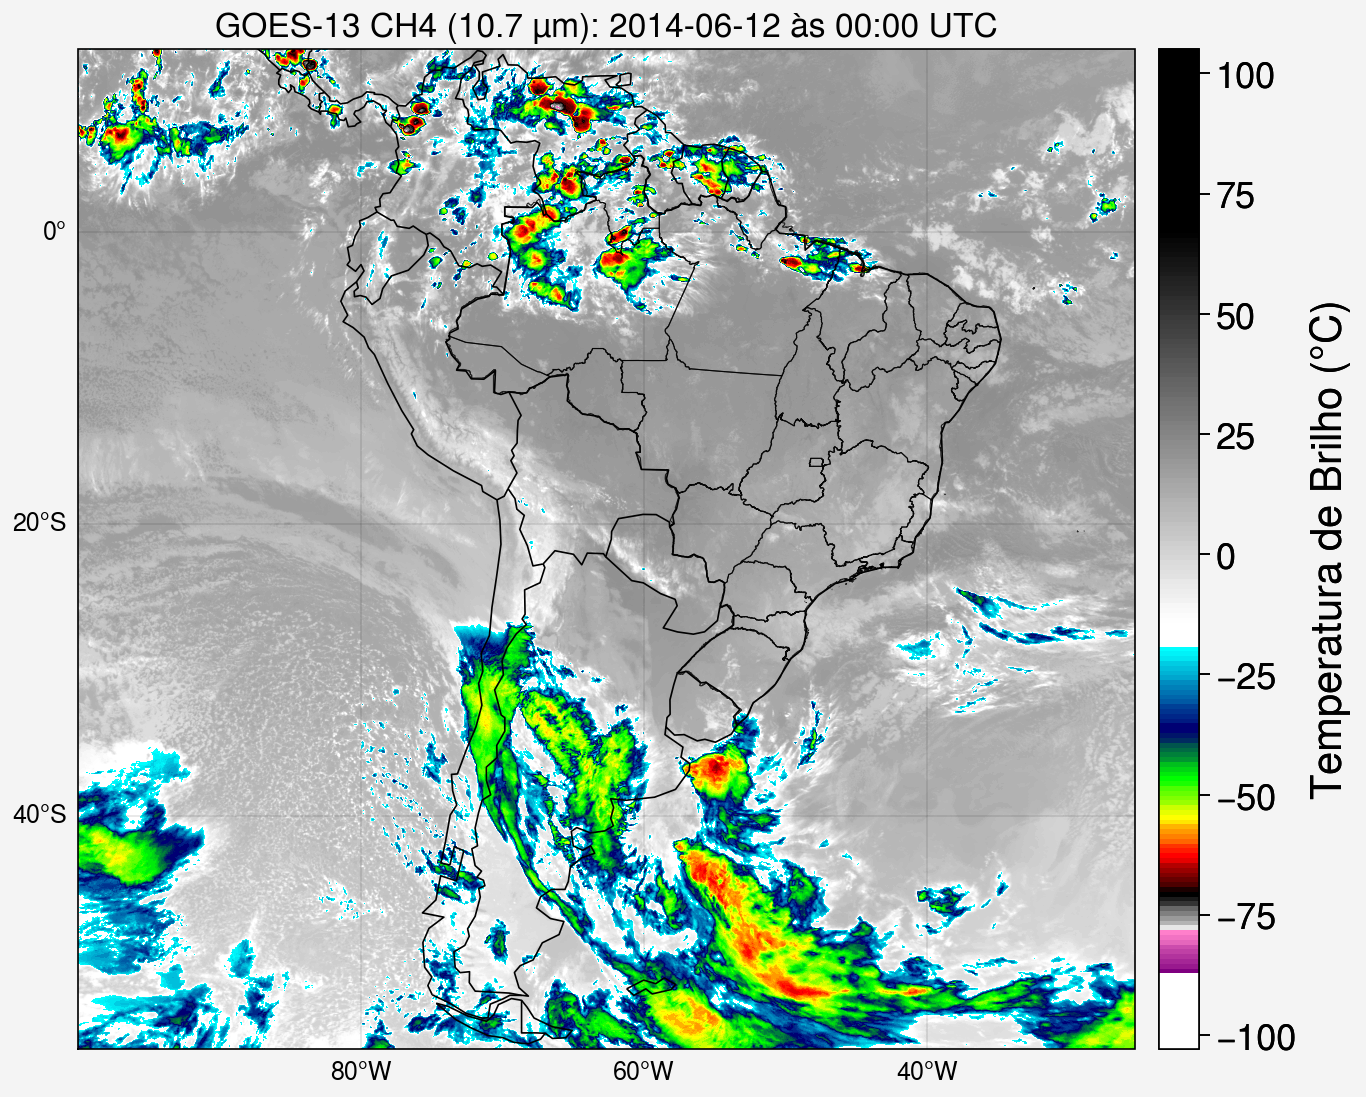

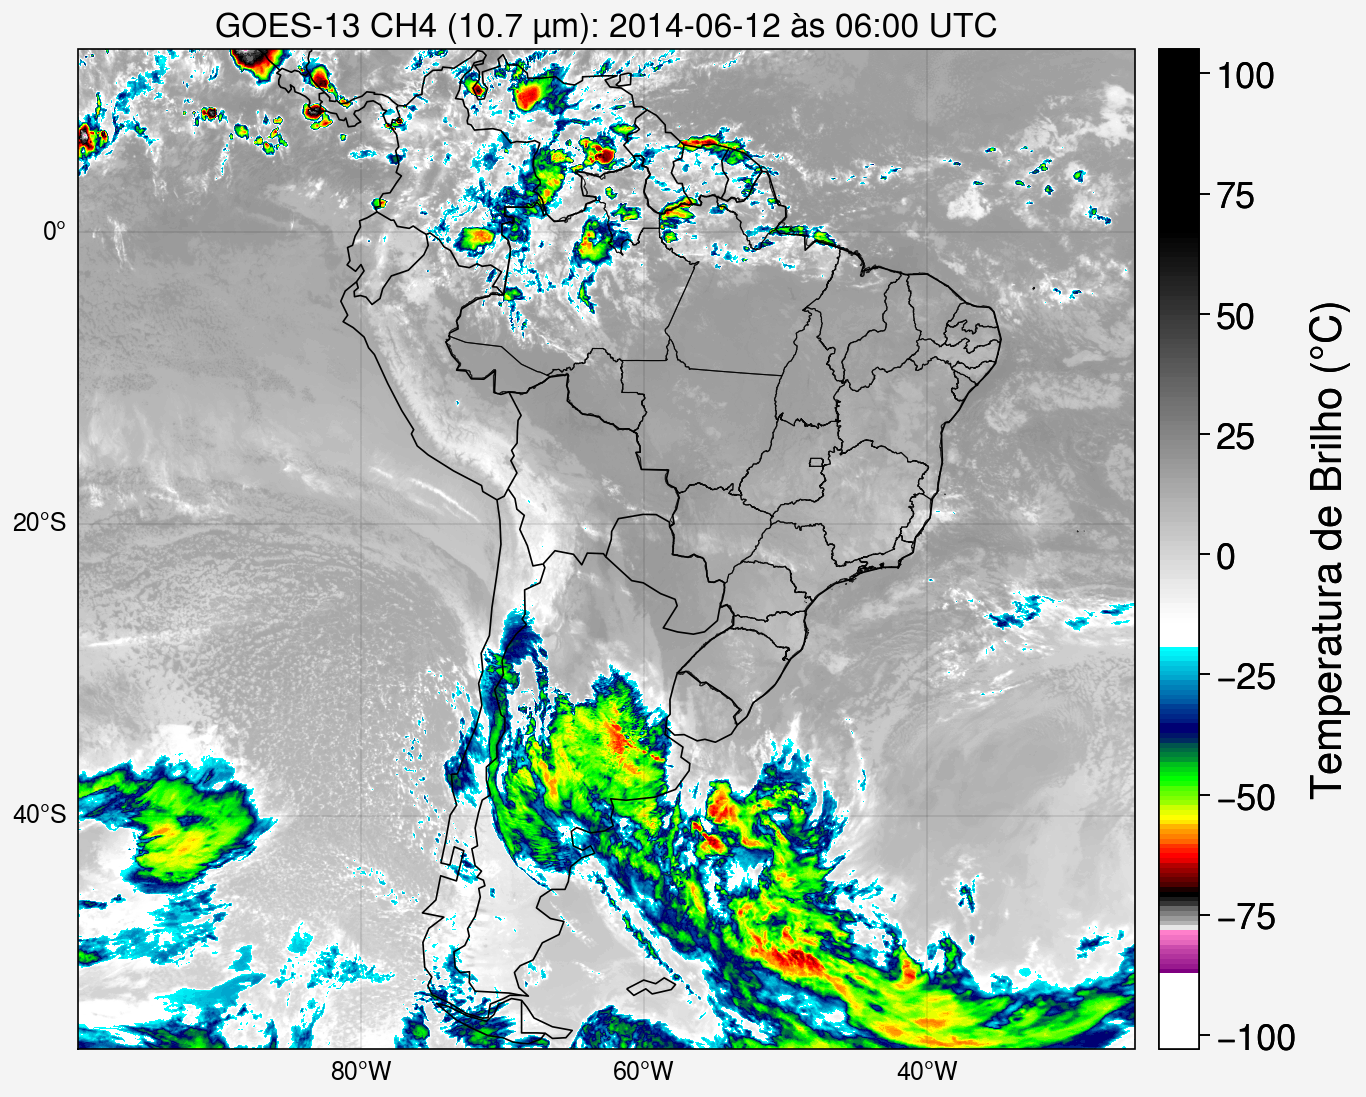

In [57]:
# Loop das imagens
for file in files_nc:

    print('....PROCESSANDO--->>>', file)

    # nome do arquivo. Exemplo: de "/content/drive/MyDrive/PYHTON/00_GITHUB/4_SATELITE/input/S10236964_201406120600" para "S10236964_201406120600"
    basename = os.path.basename(os.path.splitext(file)[0])

    # extrai a data da imagem
    ano, mes, dia, hor, minu = basename[10:14], basename[14:16], basename[16:18], basename[18:20], basename[20:22]

    #------------------------------------------------#
    # Leitura arquivo NetCdf
    #------------------------------------------------#
    # leitura do arquivo NetCdf
    tmp = xr.open_dataset(file)

    # extrai os dados
    data, lat, lon = tmp['tir'], tmp['lat'], tmp['lon']

    # é necessário inverter o eixo y, como no seguinte exemplo: tmtmp = np.flipud(tmtmp)
    #data = np.flipud(data)

    #------------------------------------#
    #          Plotando a figura
    #------------------------------------#
    # cria a moldura da figura
    fig, ax = pplt.subplots(axwidth=5.5, axheight=5, tight=True, proj='pcarree')

    # define formato da figura
    ax.format(coast=True, borders=True, innerborders=False, labels=True, latlines=20, lonlines=20,
              latlim=(latmin,latmax), lonlim=(lonmin,lonmax), fontsize=11,
              title=f'GOES-13 CH4 (10.7 µm): {ano}-{mes}-{dia} às {hor}:{minu} UTC')

    # carrega tabela de cores
    cpt_ir = loadCPT(f'{dir}input/ir.cpt')
    cmap_ir = cm.colors.LinearSegmentedColormap('cpt_ir', cpt_ir)

    # plota mapa
    map1 = ax.imshow(data,
                     cmap=cmap_ir,
                     extent=[lonmin, lonmax, latmin, latmax],
                     levels=pplt.arange(-103.0, 105, 1.0))

    # plota contornos dos Estados
    estados_ibge.plot(edgecolor='black', facecolor='none', linewidth=0.4, alpha=0.8, ax=ax)

    # plota barra de cores da figura
    fig.colorbar(map1, loc='r', label='Temperatura de Brilho ($\degree$C)', ticks=25, ticklabelsize=13, labelsize=15, space=0.1)

    # salva figura
    fig.save(f'goes13_ch4_{ano}{mes}{dia}_{hor}{minu}.jpg', dpi=300, bbox_inches='tight')